In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [0]:
# RMSLE in natural log 
def my_loss(pred, actual):
  assert len(pred) == len(actual)
  error2 = [(math.log(pred[i] + 1) - math.log(actual[i] - 1))**2 for i in range(len(pred))]
  result = np.sqrt(np.sum(error2) / len(pred))
  return result 

In [0]:
def get_loss(pred, actual):
  log_mse = mean_squared_error(np.log1p(pred), np.log1p(actual))
  result = np.sqrt(log_mse)
  return result 

In [0]:
seed = 60 #42  #36

## Load the data

In [0]:
# Import the all dataset
tr = pd.read_csv('train_3.csv')
te = pd.read_csv('test_3.csv')

In [0]:
# Import the all dataset
tr = pd.read_csv('train_3_svd.csv')
te = pd.read_csv('test_3_svd.csv')

In [8]:
tr.shape

(3000, 377)

In [0]:
y = tr.revenue_log
X = tr.drop('revenue_log', axis = 1)

In [0]:
# Split into train and Valid set
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = .2, random_state = seed)

In [292]:
print("The size of the train set ", X_tr.shape)
print("The size of the validation set ", X_val.shape)
print("The size of the test set ", te.shape)

The size of the train set  (2400, 376)
The size of the validation set  (600, 376)
The size of the test set  (4398, 376)


In [0]:
del tr, X, y, 

In [12]:
tr.iloc[:, :50].describe()

,budget_log,popularity_log,runtime_h,runtime_log,runtime_m,status,is_collection,is_homepage,n_genres,n_prod_count,n_prod_comp,n_spoken_lang,cast_male,crew_male,n_crew_profile,year,month,day,weekofday,rating,n_cast_log,n_crew_log,popularity2_log,totalVotes_log,popularity_diff_log,r_runtime_rating,r_rating_totalVotes,r_budget_rating,r_popularity_totalVotes,r_popularity_rating,r_popularity_ngenres,r_popularity_n_cast,r_budget_totalVotes,r_budget_runtime,r_budget_year,r_totalVotes_year,r_rating_year,r_rating_year2,m_rating_totalVotes,m_year_popularity,m_year_budget,m_year_totalVotes_log,m_year_rating,m_year_runtime,m_year_n_crew_log,m_weekofday_budget,_genres_Action,_genres_Adventure,_genres_Animation,_genres_Biography
count,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2984.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.0
mean,11.961359,1.975396e+00,1.239667,4.655350,-0.022999,1.001333,0.201333,0.315333,2.508000,1.351333,2.836667,1.459000,0.229156,0.091542,0.297043,1999.713000,6.775333,15.046333,3.269333,6.115900,2.845370,2.749341,2.004640,5.406852,0.297523,-0.074844,0.099161,3.885689e+06,3.431457,0.502601,3.988243e+00,6.263061e-01,8.985388e+04,2.116568e+05,2.706289e+05,0.074753,0.003059,0.088497,5.410665,8.512923,2.273950e+07,5.411259,6.115438,-0.001121,20.927257,2.246283e+07,0.247333,0.146667,0.047000,0.0
std,7.403049,7.416869e-01,0.467225,0.366837,1.002196,0.036497,0.401063,0.464726,1.111612,0.738521,2.004660,0.880479,0.148918,0.121399,0.240688,15.423313,3.409115,8.632981,1.306150,1.512808,0.688958,0.998875,0.603624,1.920214,0.247254,1.929844,0.341104,1.586896e+07,1.366334,1.273596,5.281556e+00,5.594107e+00,7.719017e+05,4.255145e+05,4.203517e+05,0.129112,0.000760,0.167192,1.108702,3.255377,9.703793e+06,0.479286,0.298785,0.140038,3.712599,6.432693e+06,0.431534,0.353832,0.211674,0.0
min,0.000000,9.999995e-07,0.000000,0.000000,-2.177292,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1921.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.470004,0.693147,0.000195,-21.772921,0.000000,0.000000e+00,-2.113439,0.000010,2.500000e-07,5.000000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.007220,0.000000,0.000000,0.690821,0.417895,1.248674e+05,2.215812,5.611607,-1.854838,9.200000,1.549484e+07,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.613042e+00,1.000000,4.553877,-0.565022,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.125000,0.000000,0.119048,1993.000000,4.000000,8.000000,2.000000,5.800000,2.484907,2.197225,1.716362,4.189655,0.117776,-0.107095,0.005911,0.000000e+00,2.574760,0.265571,1.558928e+00,2.048711e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.053036,0.002877,0.066667,5.408077,7.412260,1.324143e+07,5.126734,5.942373,-0.052490,19.090909,1.732969e+07,0.000000,0.000000,0.000000,0.0
50%,15.894952,2.125233e+00,1.000000,4.653960,0.144376,1.000000,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.208333,0.058397,0.245592,2004.000000,7.000000,15.000000,4.000000,6.400000,2.833213,2.708050,2.112755,5.575949,0.241470,0.021875,0.019385,1.232877e+06,3.409988,0.332031,2.969959e+00,3.784846e-01,2.002506e+04,7.450112e+04,1.052632e+05,0.069764,0.003179,0.076250,5.593403,7.815993,2.664833e+07,5.489345,6.060645,0.001543,20.035370,1.732969e+07,0.000000,0.000000,0.000000,0.0
75%,17.216708,2.475780e+00,1.000000,4.779123,0.724793,1.000000,0.000000,1.000000,3.000000,1.000000,4.000000,2.000000,0.327691,0.136676,0.411765,2011.000000,10.000000,22.000000,4.000000,7.000000,3.218876,3.367

In [0]:
df = pd.DataFrame()
df['val'] = y_val

## Validation Set

### 1. Elastic-Net

In [0]:
X_tr_el = X_tr.fillna(-1)
X_val_el = X_val.fillna(-1)
te_el = te.fillna(-1)

In [295]:
model_el = ElasticNet(alpha = .05, l1_ratio = .001, max_iter = 5000)
model_el.fit(X_tr_el, y_tr)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
pred_el = model_el.predict(X_val_el)

In [297]:
np.sqrt(mean_squared_error(y_val, pred_el))

2.0594729092486506

In [0]:
# 1st try: 2.1347
# 2nd try: 2.1266
# 3rd try: 2.0524 (Mean encoding)
# 1.9690

In [0]:
df['el'] = pred_el

In [0]:
te_l1['el'] = model_el.predict(te_el)

### 2. KNN 

In [0]:
# scaling?

In [310]:
model_knn = KNeighborsRegressor(n_neighbors = 15, 
                                weights = 'distance',
                                p = 2)  

model_knn.fit(X_tr_el, y_tr)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='distance')

In [311]:
pred_knn = model_knn.predict(X_val_el)
np.sqrt(mean_squared_error(y_val, pred_knn))

2.5476883416507774

In [0]:
# 3rd try: 2.1707 (Mean encoding)

In [0]:
df['knn'] = pred_knn

In [0]:
te_l1['knn'] = model_knn.predict(te_el)

## RandomForest

In [0]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators = 3000,
                                 criterion = 'mse',
                                 #min_samples_split = .7,
                                 #min_samples_leaf = 100,
                                 max_depth = 9)
model_rf.fit(X_tr_el, y_tr)
df['rf'] = model_rf.predict(X_val_el)

In [315]:
np.sqrt(mean_squared_error(y_val, df['rf']))

1.8753224956609174

In [0]:
te_l1['rf'] = model_rf.predict(te_el)

### 3. Kernel SVM

In [0]:
# scaling?

In [317]:
model_svm = SVR(kernel = 'rbf')  
model_svm.fit(X_tr_el, y_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [318]:
pred_svm = model_svm.predict(X_val_el)
np.sqrt(mean_squared_error(y_val, pred_knn))

2.5476883416507774

In [0]:
# 3rd try: 2.1707 (Mean encoding)

In [0]:
df['svm'] = pred_svm

In [0]:
te_l1['svm'] = model_svm.predict(te_el)

### 4. Xgboost

In [0]:
model_xg = xgb.XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000, 
                            max_depth = 9, 
                            learning_rate = 0.01,
                            early_stopping_rounds = 500,
                            gamma = 1.0, 
                            #alpha = .6,
                            subsample = 0.5,   
                            colsample_bytree = 0.7, 
                            colsample_bylevel = 0.7,
                            silent = True)

In [322]:
model_xg.fit(X_tr, y_tr)
    
pred_xg = model_xg.predict(X_val)
np.sqrt(mean_squared_error(y_val, pred_xg))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1.8103316676906565

In [0]:
# 1st try: 1.9202
# 2nd try: 1.9128
# 3nd try: 1.8978
# 4th try: 1.8791 (Mean encoding)    # 1.8430
# 5th try: 1.8439 (+ Voting Data)    

In [0]:
param_save = model_xg.get_params
param_save

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, early_stopping_rounds=500, gamma=1.0,
       importance_type='gain', learning_rate=0.007, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)>

In [0]:
df['xg'] = pred_xg

In [0]:
te_l1['xg'] = model_xg.predict(te)

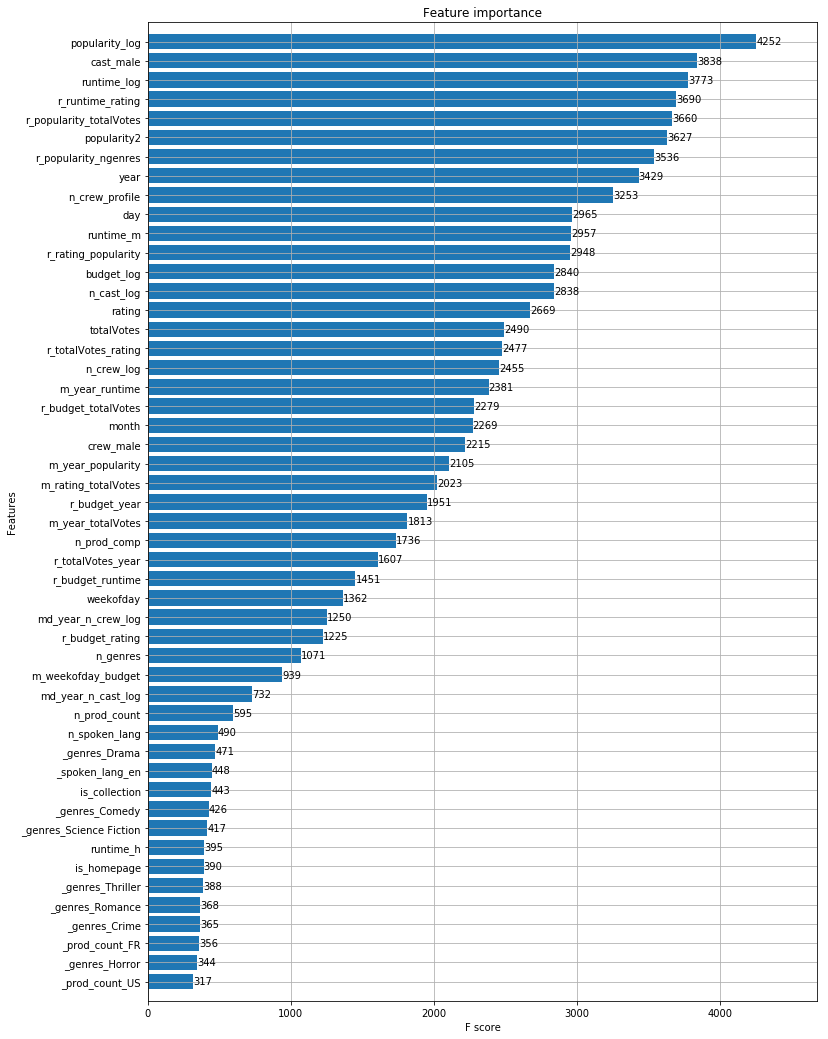

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_xg, max_num_features= 50, height=0.8, ax=ax)
plt.show()

In [0]:
import pickle
# Save the model
filename = 'model_xg.pkl'
with open(filename, 'wb') as file:
  pickle.dump(model_xg, file)

### 5. Catboost

In [327]:
model_cb = CatBoostRegressor(bagging_temperature = 0.3,  
                             colsample_bylevel = 0.7,  
                             depth = 9,   
                             early_stopping_rounds = 500,   
                             eval_metric = 'RMSE',
                             iterations = 3000,                             
                             learning_rate = .01,    
                             logging_level = 'Silent')

model_cb.fit(X_tr, y_tr, eval_set = (X_val, y_val), use_best_model = True)

In [328]:
pred_cb = model_cb.predict(X_val)
np.sqrt(mean_squared_error(y_val, pred_cb))

1.73389319000852

In [0]:
# 1st try: 1.9218
# 2nd try: 1.8779
# 3rd try: 1.8753
# 4th try: 1.8618 (Mean encoding)     # 1.73
# 5th try: 1.8268 (+ Voting Data)

In [0]:
model_cb.get_params()

{'bagging_temperature': 0.5,
 'colsample_bylevel': 0.8,
 'depth': 9,
 'early_stopping_rounds': 500,
 'eval_metric': 'RMSE',
 'iterations': 3000,
 'learning_rate': 0.05,
 'logging_level': 'Silent',
 'loss_function': 'RMSE'}

In [0]:
df['cb'] = pred_cb

In [0]:
te_l1['cb'] = model_cb.predict(te)

### 6. Lightgbm

In [331]:
!pip install lightgbm --install-option=--gpu
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [332]:
tr_data = lgb.Dataset(X_tr, label = y_tr)
val_data = lgb.Dataset(X_val, label = y_val)

params = {'objective' : 'regression',
          'num_iterations' : 10000, 
          'max_depth' : 11,
          'num_leaves' : 100,
          'learning_rate': 0.05, 
          'metric' : 'rmse',
          'min_data_in_leaf' : 100,
          'colsample_bytree': 0.6,
          'subsample_freq': 1,
          'lambda_l1' : 0.01,
          'lambda_l2' : 0.5,
          'subsample' : 0.8, 
          'verbose' : -1}

hist = {}
model_lg = lgb.train(params, tr_data, 
                     valid_sets = [val_data],
                     verbose_eval = -1, 
                     early_stopping_rounds = 500,
                     callbacks = [lgb.record_evaluation(hist)])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[326]	valid_0's rmse: 1.78603


In [333]:
pred_lg = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
np.sqrt(mean_squared_error(y_val, pred_lg))

1.7860315475624462

In [0]:
# 1st try: 
# 2nd try: 1.9138
# 3rd try: 1.9008 (Mean encoding)
# 5th try: 1.8738 (+ Voting Data)

In [0]:
model_lg.params

{'colsample_bytree': 0.8,
 'lambda_l1': 0.01,
 'lambda_l2': 0.5,
 'learning_rate': 0.003,
 'max_depth': 13,
 'metric': 'rmse',
 'min_data_in_leaf': 100,
 'num_leaves': 200,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 1,
 'verbose': -1}

In [0]:
df['lg'] = pred_lg

In [0]:
te_l1['lg'] = model_lg.predict(te_el)

### 7. Keras

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

In [336]:
print(X_tr.shape[1])
print(X_tr.shape[1] /2)

376
188.0


In [341]:
# initialize the model
model = Sequential()

# create hidden layers
model.add(Dense(input_dim = X_tr.shape[1], output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 64, activation = 'relu'))
#model.add(Dropout(.7))
model.add(BatchNormalization())
model.add(Dense(output_dim = 32, activation = 'relu'))
#model.add(Dropout(.7))
model.add(BatchNormalization())
model.add(Dense(output_dim = 16, activation = 'relu'))
#model.add(BatchNormalization())
model.add(Dense(output_dim = 1)) 

# compile: stochastic gradient descent
model.compile(optimizer = Adam(lr=0.01), 
              loss = 'mse', 
              metrics = ['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=376, activation="relu", units=128)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=32)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  del sys.path[0]


In [342]:
# early stopper 
early_stopper = EarlyStopping(patience = 5)

r = model.fit(X_tr_el, y_tr, 
              validation_data = (X_val_el, y_val),
              batch_size = 100, 
              nb_epoch = 3000,
              callbacks = [early_stopper])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 2400 samples, validate on 600 samples
Epoch 1/3000
2400/2400 [==============================] - 6s 2ms/step - loss: 121.8389 - mean_squared_error: 121.8389 - val_loss: 171.2665 - val_mean_squared_error: 171.2665
Epoch 2/3000
2400/2400 [==============================] - 0s 73us/step - loss: 12.7437 - mean_squared_error: 12.7437 - val_loss: 17.8785 - val_mean_squared_error: 17.8785
Epoch 3/3000
2400/2400 [==============================] - 0s 76us/step - loss: 8.0550 - mean_squared_error: 8.0550 - val_loss: 10.3828 - val_mean_squared_error: 10.3828
Epoch 4/3000
2400/2400 [==============================] - 0s 73us/step - loss: 7.1528 - mean_squared_error: 7.1528 - val_loss: 10.4130 - val_mean_squared_error: 10.4130
Epoch 5/3000
2400/2400 [==============================] - 0s 74us/step - loss: 6.3841 - mean_squared_error: 6.3841 - val_loss: 19.1982 - val_mean_squared_error: 19.1982
Epoch 6/3000
2400/2400 [==============================] - 0s 72us/step - loss: 6.2629 - mean_squared_

In [343]:
# prediction 
pred_ke = model.predict(X_val)
np.sqrt(mean_squared_error(y_val, pred_ke))

2.388245509839219

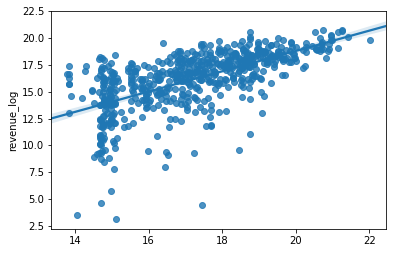

In [344]:
sns.regplot(x = pred_ke, y = y_val)

In [0]:
# 1st try : 2.9460
# 2nd try : 2.9338 (Mean Encoding)

In [0]:
df['ke'] = pred_ke

In [0]:
te_l1['ke'] = model.predict(te_el)

In [0]:
lr_vals = [0.005, 0.01, 0.05, 0.1]

for lr in lr_vals:
    my_optimizer = RMSprop(lr = lr)
    model.compile(optimizer = my_optimizer, loss = 'mse', metrics = ['mean_squared_logarithmic_error'])
    model.fit(X_tr, y_tr,
              validation_data = (X_val, y_val),
              batch_size = 100,
              nb_epoch = 1000,
              callbacks = [early_stopper])
    
    print("==========================")
    pred_ke = model.predict(X_val)
    loss = np.sqrt(mean_squared_error(y_val, pred_ke))
    print("Learning Rate: {}, RMSE: {}".format(lr, loss))
    print("==========================")

In [0]:
# plot the error
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'valid loss')
plt.legend()
plt.show()

plt.plot(r.history['mean_squared_logarithmic_error'], label = 'train mse')
plt.plot(r.history['val_mean_squared_logarithmic_error'], label = 'valid mse')
plt.legend()
plt.show()

## Evaluation

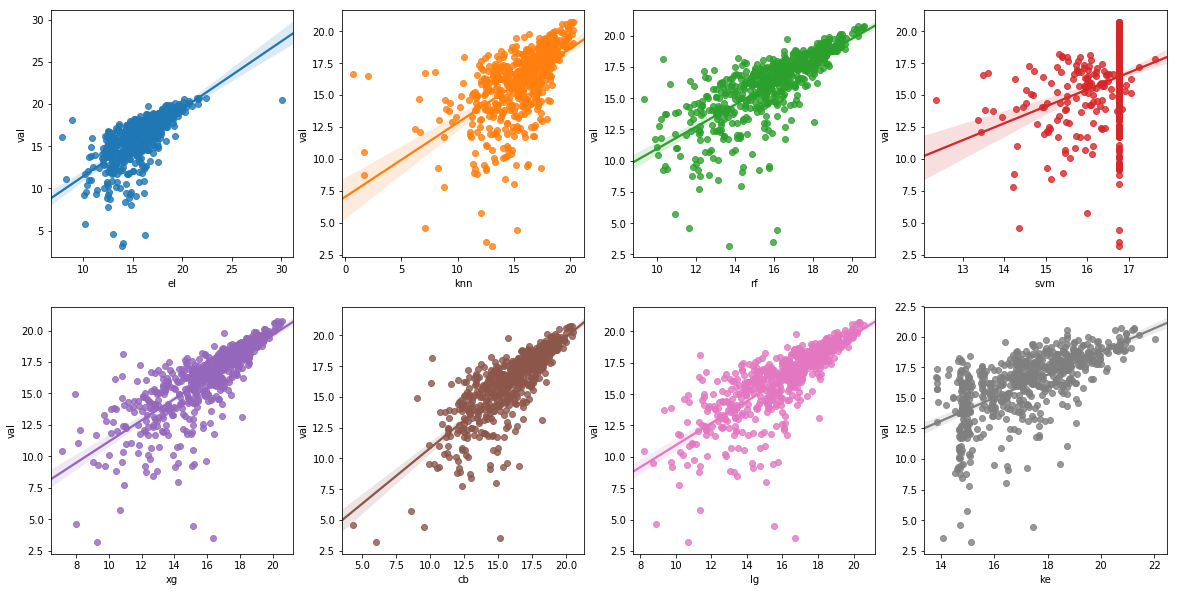

In [347]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

for i, col in enumerate(df.columns[1:]):
  sns.regplot(x = col, y = 'val', data = df, ax = axes[i//4, i%4])

In [388]:
df.head()

,val,el,knn,rf,svm,xg,cb,lg,ke
1574,8.810012,12.389611,11.690437,11.784755,14.234154,10.426545,11.952409,11.280832,14.925463
470,14.329968,12.138924,13.435323,11.665911,16.762393,11.144157,12.368020,12.870798,18.741896
970,16.118096,14.738245,13.333591,14.965088,16.762393,15.050518,14.812736,15.838996,15.578290
213,17.249498,15.046225,15.999929,15.407578,16.762393,15.267167,15.036150,15.949552,16.131329
2588,15.175864,17.111498,11.353663,16.473388,16.762393,15.732118,16.288759,15.746159,15.549747


In [0]:
num = 4
filename = 'stack_train_' + str(num) + '.csv'
df.to_csv(filename, index = False)
files.download(filename)

In [350]:
te_l1.head()

,el,knn,rf,svm,xg,cb,lg,ke
0,14.396893,16.913128,14.560579,16.874601,17.699179,15.035665,15.438895,14.627176
1,13.769597,15.684968,14.272217,16.762393,13.243937,13.392078,14.295852,17.522978
2,14.826556,15.067891,16.077278,16.034189,16.910257,15.740754,17.195869,14.836325
3,16.427793,14.294191,15.779022,16.762393,15.730898,16.535145,16.003183,16.273699
4,14.573322,14.745218,13.473338,16.762393,14.866657,14.050694,13.973440,15.369491


In [0]:
filename = 'stack_test_' + str(num) + '.csv'
te_l1.to_csv(filename, index = False)
files.download(filename)